# Automatic Multi-target Multiverse

We develop this tool to provide a global visualization of relationships of compounnd data sets annotated with multiple biological activity. The code can use datasets in CSV, XLSX, TVS, JSON and XML format.


To use the funtion *chemical_multiverse* it is necessary define some arguments:


*   dataset: File name and path
*   smiles_column_name: Name of the column that collects the SMILES notation
*   ID: Name of the column that contain the ID of each compound
*   target_activities: A list that collects the name of all the columns with activity value of each target
*   MACCS: Define as Truse or False depending on if it is required
*   ECFP: Define as True or False depending on if it is required
*   MD: Enlist 6 molecualr descriptors, molecular weight (MH), partition coefficient (LogP), topological polar surface area (TPSA), number o hydrogen bond donors (HBA), number of hydrogen bond acceptor (HBD) and number of rotable bond (RB). Define as True or Falce depending on if it is required
*   vPCA: Define as True or Falce depending on if it is required
*   t-SNE: Define as True or False dependig on if it is required

Example:

```
chemical_multiverse(file='/content/example.csv', smiles_column_name='SMILES', target_activities=['Target_1', 'Target_2', 'Target_3'], MACCS=Falce, ECFP=True, MD=Falce, vPCA=True, t-SNE=True )
```



The tool performe:

1. Dataset curation
2. Generation of chemical spaces based on similarity calculation with three groups of descriptores; MACCS keys, ECFP and six molecular descriptors with pharmacological relevance
3. Dimensionality reduction to generate 2D visual representations of the chemical spaces.




# Modules


In [ ]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Instalar rdkit
      !pip -q install rdkit
      pbar.update(5)
      !pip install pandas
      !pip install dash
      pbar.update(10)
      # Instalar Numpy
      !pip install numpy
      # Instalar Pillow
      !pip -q install Pillow
      pbar.update(20)
      # Instalar Molvs
      !pip install -q molvs
      !pip install kora py3Dmol
      pbar.update(30)
      # Instalar Components
      !pip install dash-bootstrap-components
      pbar.update(50)
      # Instalar molplotly
      !pip install molplotly
      !pip install matplotlib
      pbar.update(60)
      # Chembl
      !pip install chembl_webresource_client
      pbar.update(70)
      #Seaborn
      !pip install seaborn
      # Instalar Pillow
      !pip -q install Pillow
      # Instalar jupyter-dash
      !pip install jupyter-dash
      pbar.update(80)
      # Instalar el diseño de aplicación dash
      !pip install dash-bootstrap-components
      pbar.update(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#Dataframe
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
! pip install kaleido
import kaleido
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd
import molplotly
import os
#Chemoinformatic
from rdkit import Chem, RDConfig
import csv
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools, Scaffolds
from rdkit.Chem import Descriptors, Descriptors3D
import kora.install.rdkit
import py3Dmol
PandasTools.RenderImagesInAllDataFrames(images=True)
#Data frames
from rdkit.Chem import rdMolDescriptors
from molvs.standardize import Standardizer
from molvs.charge import Uncharger, Reionizer
from molvs.fragment import LargestFragmentChooser
from molvs.tautomer import TautomerCanonicalizer
from rdkit.Chem.rdmolops import GetFormalCharge, RemoveStereochemistry
from sklearn.preprocessing import StandardScaler
import dash_bootstrap_components as dbc
from sys import argv
from rdkit.Chem import MACCSkeys, RDKFingerprint, Pharm2D
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.Draw import IPythonConsole
import math
import plotly.express as px
import molplotly
from math import pi
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from IPython.display import display, SVG, HTML
import json
from pathlib import Path
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import get_as_dataframe
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import get_as_dataframe
!pip install kora py3Dmol
import kora.install.rdkit
import py3Dmol
from scipy.spatial import distance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.7 MB/s eta 0:00:00


# Funtion

In [ ]:
def chemical_multiverse(dataset, ID=None, smiles_column_name=None, target_activities=[None], vPCA=True, t_SNE=True, MACCS=True, ECFP=True, MD=True, palette=["#262254", "#543884", "#A13670", "#AC4176", '#FFA45E'], perplexity=33):

    if dataset.endswith('.csv'):
        input_df = pd.read_csv(dataset)
    elif dataset.endswith('.xlsx'):
        input_df = pd.read_excel(dataset)
    elif dataset.endswith('.tsv'):
        input_df = pd.read_csv(dataset, delimiter='\t')
    elif dataset.endswith('.json'):
        input_df = pd.read_json(dataset)
    elif dataset.endswith('.xml'):
        input_df = pd.read_xml(dataset)
    else:
        raise ValueError("Formato de archivo no soportado")

    if smiles_column_name is None:
        raise TypeError('Warning: It is necessary to specify the name of the smiles column')
    if ID is None:
        raise TypeError('Warning: It is necessary to specify the name of the ID column')
    if target_activities is None:
        raise TypeError('Warning: It is necessary to specify the list name of the activity column')

    STD = Standardizer()
    LFC = LargestFragmentChooser()
    UC = Uncharger()
    RI = Reionizer()
    TC = TautomerCanonicalizer()

    def pretreatment(smi):
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                return "Error 1"
            mol = STD(mol)
            mol = LFC(mol)
            allowed_elements = {"H","B","C","N","O","F","Si","P","S","Cl","Se","Br","I"}
            actual_elements = set([atom.GetSymbol() for atom in mol.GetAtoms()])
            if len(actual_elements-allowed_elements) == 0:
                mol = UC(mol)
                mol = RI(mol)
                mol = TC(mol)
                return Chem.MolToSmiles(mol)
            else:
                return "Error 2"
        except Exception as e:
            return f'Something else was found'

    input_df["Canonical Smiles"] = input_df[smiles_column_name].apply(pretreatment)
    input_df = input_df[input_df["Canonical Smiles"] != "Error 1"]
    input_df = input_df[input_df["Canonical Smiles"] != "Error 2"]
    input_df = input_df[input_df["Canonical Smiles"] != "Something else was found"].reset_index(drop=True)

    for activity_target in target_activities:

      input_df['Activity Index'] = -np.log(input_df[target_activities]).mean(axis=1)
      input_df['std'] = input_df[target_activities].std(axis=1)
      input_df['norma'] = ((input_df['std'] - input_df['std'].min()) / (input_df['std'].max() - input_df['std'].min()))
      input_df['normal_desviation'] = input_df['norma'] * (12-7)+5
      input_df['normal_desviation'].fillna(7, inplace=True)

    if MACCS is True:

              def similarity_calc(smi1, smi2, method='tanimoto'):
                mol1 = Chem.MolFromSmiles(smi1)
                mol2 = Chem.MolFromSmiles(smi2)
                fp1 = MACCSkeys.GenMACCSKeys(mol1)
                fp2 = MACCSkeys.GenMACCSKeys(mol2)
                if method == 'tanimoto':
                    similarity = round(DataStructs.TanimotoSimilarity(fp1, fp2), 3)
                elif method == 'dice':
                    similarity = round(DataStructs.DiceSimilarity(fp1, fp2), 3)
                elif method == 'cosine':
                    similarity = round(DataStructs.CosineSimilarity(fp1, fp2), 3)
                elif method == 'euclidean':
                    similarity = round(np.linalg.norm(arr1 - arr2), 3)
                else:
                    raise ValueError("Method not recognized. Please use 'tanimoto', 'dice', 'cosine', or 'euclidean'.")
                return similarity

              matrix_values=np.zeros((len(input_df), len(input_df)))

              for i in input_df.index:
                  for j in input_df.index:
                          a=input_df.loc[i].at['Canonical Smiles']
                          b=input_df.loc[j].at['Canonical Smiles']
                          alignment= similarity_calc(a,b, 'tanimoto')
                          matrix_values[i,j]=alignment
                          matrix_MACCS = pd.DataFrame(matrix_values, index=input_df[ID], columns=input_df[ID])
                          df_MACCS = pd.DataFrame(matrix_MACCS)

              if vPCA is True:
                    data_MACCS = matrix_MACCS.iloc[:,0:].values
                    pd.DataFrame(data_MACCS)
                    label_MACCS = input_df.iloc[:,0].values
                    pca_MACCS = PCA(n_components=2)
                    pca_results_MACCS = pca_MACCS.fit_transform(data_MACCS)
                    label_MACCS = input_df[[ID, smiles_column_name]]
                    label_MACCS = label_MACCS.to_numpy()
                    arr = np.concatenate((label_MACCS,pca_results_MACCS), axis = 1)
                    data_MACCS_PCA = pd.DataFrame(data=arr, columns = [ID, smiles_column_name, 'component1', 'component2'])
                    pca = PCA()
                    X_train_pca = pca.fit_transform(data_MACCS)
                    exp_var_pca = pca.explained_variance_ratio_

                    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
                    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
                    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
                    plt.ylabel('Explained variance ratio')
                    plt.xlabel('Principal component index')
                    plt.legend(loc='best')
                    plt.tight_layout()
                    dataset_MACCS_PCA= pd.merge(data_MACCS_PCA, input_df, on=smiles_column_name, how='inner')
                    x_label = f'component1 {exp_var_pca[0]}'
                    y_label = f'component2 {exp_var_pca[1]}'
                    fig_pca = px.scatter(
                        dataset_MACCS_PCA,
                        x='component1',
                        y='component2',
                        color='Activity Index',
                        color_continuous_scale=palette,
                        title='PCA - MACCS',
                        labels={
                            'component1': f'Component 1 ({exp_var_pca[0]*100:.3}%)',
                            'component2': f'Component 2 ({exp_var_pca[1]*100:.3}%)'},
                          width=900,
                          height=700)
                    fig_pca.update_traces(
                      marker=dict(
                        size=input_df['normal_desviation'],
                        symbol='circle',
                        line=dict(
                            width=1,
                            color='DarkSlateGrey'
                                  )))
                    fig_pca.update_layout(
                      plot_bgcolor='white',
                      paper_bgcolor='white',
                      xaxis=dict(
                          showgrid=True,
                          gridcolor='lightgrey',
                          gridwidth=0.5,
                          griddash='dot',
                          zerolinecolor='lightgrey',
                      ),
                      yaxis=dict(
                          showgrid=True,
                          gridcolor='lightgrey',
                          gridwidth=0.5,
                          griddash='dot',
                          zerolinecolor='lightgrey',
                      ))
                    app_marker = molplotly.add_molecules(
                      fig=fig_pca,
                      df=dataset_MACCS_PCA,
                      smiles_col=smiles_column_name,
                      title_col=smiles_column_name,
                      color_col='Activity Index')
                    fig_pca.show()
                    fig_pca.write_image("fig_pca.png", scale=2)
                    #app_marker.run(port=8060)

              if t_SNE is True:
                      data_tsne_MACCS = matrix_MACCS.copy()
                      tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=300)
                      tsne_results_MACCS = tsne.fit_transform(data_tsne_MACCS)
                      label =input_df[[ID, smiles_column_name]]
                      label = label.to_numpy()
                      arr = np.concatenate((label, tsne_results_MACCS), axis = 1)
                      tsne_data = pd.DataFrame(data=arr, columns = [ID, smiles_column_name, 'axis 1', 'axis 2'] )
                      all_dataset_tSNE = pd.merge(tsne_data, input_df, on=smiles_column_name, how='inner')
                      fig_tsne_MACCS = px.scatter(all_dataset_tSNE,
                                                  x='axis 1',
                                                  y='axis 2',
                                                  #symbol='Minimum Degree',
                                                  color='Activity Index',
                                                  color_continuous_scale=palette,
                                                  title='T-SNE - MACCS',
                                                  labels={'axis 1': 'Axis 1',
                                                          'axis 2': 'Axis 2'},
                                                  width=900,
                                                  height=700)
                      fig_tsne_MACCS.update_traces(
                        marker=dict(
                          size=input_df['normal_desviation'],
                          symbol='circle',
                          line=dict(
                              width=1,
                              color='DarkSlateGrey')))
                      fig_tsne_MACCS.update_layout(
                        plot_bgcolor='white',
                        paper_bgcolor='white',
                        xaxis=dict(
                            showgrid=True,
                            gridcolor='lightgrey',
                            gridwidth=0.5,
                            griddash='dot',
                            zerolinecolor='lightgrey',
                        ),
                        yaxis=dict(
                            showgrid=True,
                            gridcolor='lightgrey',
                            gridwidth=0.5,
                            griddash='dot',
                            zerolinecolor='lightgrey',
                        ))
                      app_marker = molplotly.add_molecules(
                        fig=fig_tsne_MACCS,
                        df=all_dataset_tSNE,
                        smiles_col= 'Canonical Smiles',
                        title_col='Canonical Smiles',
                        color_col='Activity Index')
                      fig_tsne_MACCS.show()
                      fig_tse_MACCS.write_image("figtsne_pca.png", scale=2)
                      #app_marker.run(port=8060)

    if ECFP is True:
                def similarity_calc(smi1, smi2, method='tanimoto'):
                  mol1 = Chem.MolFromSmiles(smi1)
                  mol2 = Chem.MolFromSmiles(smi2)
                  fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
                  fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
                  if method == 'tanimoto':
                      similarity = round(DataStructs.TanimotoSimilarity(fp1, fp2), 3)
                  elif method == 'dice':
                      similarity = round(DataStructs.DiceSimilarity(fp1, fp2), 3)
                  elif method == 'cosine':
                      similarity = round(DataStructs.CosineSimilarity(fp1, fp2), 3)
                  elif method == 'euclidean':
                      similarity = round(np.linalg.norm(arr1 - arr2), 3)
                  else:
                      raise ValueError("Method not recognized. Please use 'tanimoto', 'dice', 'cosine', or 'euclidean'.")
                  return similarity

                matrix_values_ECFP=np.zeros((len(input_df), len(input_df)))

                for i in input_df.index:
                    for j in input_df.index:
                          a=input_df.loc[i].at['Canonical Smiles']
                          b=input_df.loc[j].at['Canonical Smiles']
                          alignment= similarity_calc(a,b, 'tanimoto')
                          matrix_values_ECFP[i,j]=alignment
                          matrix_ECFP = pd.DataFrame(matrix_values_ECFP, index=input_df[ID], columns=input_df[ID])
                          df_ECFP = pd.DataFrame(matrix_ECFP)
                if vPCA is True:
                      data_ECFP = matrix_ECFP.iloc[:,0:].values
                      pd.DataFrame(data_ECFP)
                      label_ECFP = input_df.iloc[:,0].values
                      pca_ECPF = PCA(n_components=2)
                      pca_results_ECFP = pca_ECPF.fit_transform(data_ECFP)
                      label_ECFP = input_df[[ID, smiles_column_name]]
                      label_ECFP = label_ECFP.to_numpy()
                      arr = np.concatenate((label_ECFP,pca_results_ECFP), axis = 1)
                      data_ECFP_PCA = pd.DataFrame(data=arr, columns = [ID, smiles_column_name, 'component1', 'component2'])
                      sc = StandardScaler()
                      sc.fit(data_ECFP)
                      X_train_std = sc.transform(data_ECFP)
                      pca = PCA()
                      X_train_pca = pca.fit_transform(X_train_std)
                      exp_var_pca = pca.explained_variance_ratio_
                      exp_var_pca
                      cum_sum_eigenvalues = np.cumsum(exp_var_pca)
                      plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
                      plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
                      plt.ylabel('Explained variance ratio')
                      plt.xlabel('Principal component index')
                      plt.legend(loc='best')
                      plt.tight_layout()
                      dataset_ECFP_PCA= pd.merge(data_ECFP_PCA, input_df, on=smiles_column_name, how='inner')
                      x_label = f'component1 {exp_var_pca[0]}'
                      y_label = f'component2 {exp_var_pca[1]}'
                      fig_pca_ECFP = px.scatter(
                          dataset_ECFP_PCA,
                          x='component1',
                          y='component2',
                          color='Activity Index',
                          color_continuous_scale=palette,
                          title='PCA - ECFP6',
                          labels={
                              'component1': f'Component 1 ({exp_var_pca[0]*100:.3}%)',
                              'component2': f'Component 2 ({exp_var_pca[1]*100:.3}%)'},
                            width=900,
                            height=700)
                      fig_pca_ECFP.update_traces(
                        marker=dict(
                          size=input_df['normal_desviation'],
                          symbol='circle',
                          line=dict(
                              width=1,
                              color='DarkSlateGrey')))
                      fig_pca_ECFP.update_layout(
                        plot_bgcolor='white',
                        paper_bgcolor='white',
                        xaxis=dict(
                            showgrid=True,
                            gridcolor='lightgrey',
                            gridwidth=0.5,
                            griddash='dot',
                            zerolinecolor='lightgrey',),
                        yaxis=dict(
                            showgrid=True,
                            gridcolor='lightgrey',
                            gridwidth=0.5,
                            griddash='dot',
                            zerolinecolor='lightgrey',))
                      app_marker = molplotly.add_molecules(
                        fig=fig_pca_ECFP,
                        df=dataset_ECFP_PCA,
                        smiles_col='Canonical Smiles',
                        title_col='Canonical Smiles',
                        color_col='Activity Index')
                      fig_pca_ECFP.show()
                      fig_pca_ECFP.write_image("fig_pca_ECFP.png", scale=2)
                      #app_marker.run(port=8060)
                if t_SNE is True:
                      data_tsne_ECFP = matrix_ECFP.copy()
                      tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=300)
                      tsne_results_ECFP = tsne.fit_transform(data_tsne_ECFP)
                      label =input_df[[ID, smiles_column_name]]
                      label = label.to_numpy()
                      arr = np.concatenate((label, tsne_results_ECFP), axis = 1)
                      tsne_data_ECFP = pd.DataFrame(data=arr, columns = [ID, smiles_column_name, 'axis 1', 'axis 2'] )
                      dataset_tSNE_ECFP = pd.merge(tsne_data_ECFP, input_df, on=smiles_column_name, how='inner')
                      fig_tsne_ECFP = px.scatter(dataset_tSNE_ECFP,
                                                  x='axis 1',
                                                  y='axis 2',
                                                  #symbol='Minimum Degree',
                                                  color='Activity Index',
                                                  color_continuous_scale=palette,
                                                  title='t-SNE - ECFP6',
                                                  labels={'axis 1': 'Axis 1', 'axis 2': 'Axis 2'},
                                                  width=900, height=700)
                      fig_tsne_ECFP.update_traces(
                        marker=dict(
                          size=input_df['normal_desviation'],
                          symbol='circle',
                          line=dict(
                              width=1,
                              color='DarkSlateGrey')))
                      fig_tsne_ECFP.update_layout(
                        plot_bgcolor='white',
                        paper_bgcolor='white',
                        xaxis=dict(
                            showgrid=True,
                            gridcolor='lightgrey',
                            gridwidth=0.5,
                            griddash='dot',
                            zerolinecolor='lightgrey',),
                        yaxis=dict(
                            showgrid=True,
                            gridcolor='lightgrey',
                            gridwidth=0.5,
                            griddash='dot',
                            zerolinecolor='lightgrey',))
                      app_marker = molplotly.add_molecules(
                        fig=fig_tsne_ECFP,
                        df=dataset_tSNE_ECFP,
                        smiles_col='Canonical Smiles',
                        title_col='Canonical Smiles',
                        color_col='Activity Index')
                      fig_tsne_ECFP.show()
                      fig_tsne_ECFP.write_image("fig_tsne_ECFP.png", scale=2)
                      #app_marker.run(port=8060)

    if MD is True:
          smiles_list = input_df[[ID,'Canonical Smiles']]
          descriptors_df = pd.DataFrame({
            "HBA": [Descriptors.NumHAcceptors(y) for y in (Chem.MolFromSmiles(x) for x in smiles_list["Canonical Smiles"])],
            "LogP": [Descriptors.MolLogP(y) for y in (Chem.MolFromSmiles(x) for x in smiles_list["Canonical Smiles"])],
            "TPSA": [Descriptors.TPSA(y) for y in (Chem.MolFromSmiles(x) for x in smiles_list["Canonical Smiles"])],
            "MW": [Descriptors.MolWt(y) for y in (Chem.MolFromSmiles(x) for x in smiles_list["Canonical Smiles"])],
            "HBD": [Descriptors.NumHDonors(y) for y in (Chem.MolFromSmiles(x) for x in smiles_list["Canonical Smiles"])],
            "RB": [Descriptors.NumRotatableBonds(y) for y in (Chem.MolFromSmiles(x) for x in smiles_list["Canonical Smiles"])]
        }, index=smiles_list.index)

          smiles_list = smiles_list.join(descriptors_df)
          descriptors_values = smiles_list.iloc[:,2:8].values
          molecular_descriptors_data_std = StandardScaler().fit_transform(descriptors_values)
          df_MD = pd.DataFrame(molecular_descriptors_data_std)

          if vPCA is True:
              pca = PCA(n_components=2)
              pca_results_MD = pca.fit_transform(molecular_descriptors_data_std)
              label = input_df[[ID, smiles_column_name]]
              label = label.to_numpy()
              arr = np.concatenate((label,pca_results_MD), axis = 1)
              data_MD_PCA = pd.DataFrame(data=arr, columns = [ID, smiles_column_name, 'component1', 'component2'])
              sc = StandardScaler()
              sc.fit(molecular_descriptors_data_std)
              X_train_std = sc.transform(molecular_descriptors_data_std)
              pca = PCA()
              X_train_pca = pca.fit_transform(X_train_std)
              exp_var_pca = pca.explained_variance_ratio_
              exp_var_pca
              cum_sum_eigenvalues = np.cumsum(exp_var_pca)
              plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
              plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
              plt.ylabel('Explained variance ratio')
              plt.xlabel('Principal component index')
              plt.legend(loc='best')
              plt.tight_layout()
              dataset_MD_PCA= pd.merge(data_MD_PCA, input_df, on=smiles_column_name, how='inner')
              x_label = f'component1 {exp_var_pca[0]}'
              y_label = f'component2 {exp_var_pca[1]}'
              fig_pca_MD = px.scatter(
                  dataset_MD_PCA,
                  x='component1',
                  y='component2',
                  color='Activity Index',
                  color_continuous_scale=palette,
                  title='PCA - Molecular Descriptors',
                  labels={
                      'component1': f'Component 1 ({exp_var_pca[0]*100:.3}%)',
                      'component2': f'Component 2 ({exp_var_pca[1]*100:.3}%)'},
                    width=900,
                    height=700)
              fig_pca_MD.update_traces(
                marker=dict(
                  size=input_df['normal_desviation'],
                  symbol='circle',
                  line=dict(
                      width=1,
                      color='DarkSlateGrey')))
              fig_pca_MD.update_layout(
                plot_bgcolor='white',
                paper_bgcolor='white',
                xaxis=dict(
                    showgrid=True,
                    gridcolor='lightgrey',
                    gridwidth=0.5,
                    griddash='dot',
                    zerolinecolor='lightgrey',),
                yaxis=dict(
                    showgrid=True,
                    gridcolor='lightgrey',
                    gridwidth=0.5,
                    griddash='dot',
                    zerolinecolor='lightgrey',))
              app_marker = molplotly.add_molecules(
                fig=fig_pca_MD,
                df=dataset_MD_PCA,
                smiles_col='Canonical Smiles',
                title_col='Canonical Smiles',
                color_col='Activity Index')
              fig_pca_MD.show()
              fig_pca_MD.write_image("fig_pca_MD.png", scale=2)
              #app_marker.run(port=8060)

          if t_SNE is True:
                tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity, n_iter=300)
                tsne_results_MD = tsne.fit_transform(molecular_descriptors_data_std)
                label =input_df[[ID, smiles_column_name]]
                label = label.to_numpy()
                arr = np.concatenate((label, tsne_results_MD), axis = 1)
                tsne_data_MD = pd.DataFrame(data=arr, columns = [ID, smiles_column_name, 'axis 1', 'axis 2'] )
                dataset_tSNE_MD = pd.merge(tsne_data_MD, input_df, on=smiles_column_name, how='inner')
                fig_tsne_MD = px.scatter(dataset_tSNE_MD,
                                            x='axis 1',
                                            y='axis 2',
                                            #symbol='Minimum Degree',
                                            color='Activity Index',
                                            color_continuous_scale = palette,
                                            title='t-SNE - Molecular Descriptors',
                                            labels={'axis 1': 'Axis 1',
                                                    'axis 2': 'Axis 2'},
                                            width=900,
                                            height=700)
                fig_tsne_MD.update_traces(
                  marker=dict(
                    size=input_df['normal_desviation'],
                    symbol='circle',
                    line=dict(
                        width=1,
                        color='DarkSlateGrey')))
                fig_tsne_MD.update_layout(
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  xaxis=dict(
                      showgrid=True,
                      gridcolor='lightgrey',
                      gridwidth=0.5,
                      griddash='dot',
                      zerolinecolor='lightgrey',
                  ),
                  yaxis=dict(
                      showgrid=True,
                      gridcolor='lightgrey',
                      gridwidth=0.5,
                      griddash='dot',
                      zerolinecolor='lightgrey',))
                app_marker = molplotly.add_molecules(
                  fig=fig_tsne_MD,
                  df=dataset_tSNE_MD,
                  smiles_col='Canonical Smiles',
                  title_col='Canonical Smiles',
                  color_col='Activity Index')
                fig_tsne_MD.show()
                fig_tsne_MD.write_image("fig_tse_MD.png", scale=2)
                #app_marker.run(port=8060)

# Example

/usr/local/lib/python3.10/dist-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



/usr/local/lib/python3.10/dist-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



/usr/local/lib/python3.10/dist-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



/usr/local/lib/python3.10/dist-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



/usr/local/lib/python3.10/dist-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



/usr/local/lib/python3.10/dist-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



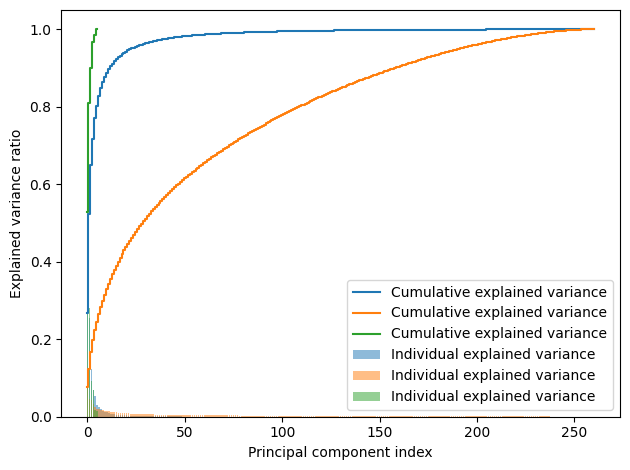

In [ ]:
chemical_multiverse('/content/study_case_avg.xlsx', smiles_column_name='Smiles', ID='molecule_chembl_id', target_activities=['Target 1 Activity','Target 2 Activity'], perplexity=7, MACCS=False)